In [1]:
import sys                       
sys.path.append('../scripts/')
from ideal_robot import *
from scipy.stats import expon, norm, uniform

In [2]:
class Robot(IdealRobot):
        
    def __init__(self, pose, agent=None, sensor=None, color="black", \
                           noise_per_meter=5, noise_std=math.pi/60, bias_rate_stds=(0.1,0.1), \
                           expected_stuck_time=1e100, expected_escape_time = 1e-100,\
                           expected_kidnap_time=1e100, kidnap_range_x = (-5.0,5.0), kidnap_range_y = (-5.0,5.0)): #追加
        super().__init__(pose, agent, sensor, color)
        self.noise_pdf = expon(scale=1.0/(1e-100 + noise_per_meter))
        self.distance_until_noise = self.noise_pdf.rvs()
        self.theta_noise = norm(scale=noise_std)
        self.bias_rate_nu = norm.rvs(loc=1.0, scale=bias_rate_stds[0])
        self.bias_rate_omega = norm.rvs(loc=1.0, scale=bias_rate_stds[1]) 
        
        self.stuck_pdf = expon(scale=expected_stuck_time) 
        self.escape_pdf = expon(scale=expected_escape_time)
        self.is_stuck = False
        self.time_until_stuck = self.stuck_pdf.rvs()
        self.time_until_escape = self.escape_pdf.rvs()
        
        self.kidnap_pdf = expon(scale=expected_kidnap_time) 
        self.time_until_kidnap = self.kidnap_pdf.rvs()
        rx, ry = kidnap_range_x, kidnap_range_y
        self.kidnap_dist = uniform(loc=(rx[0], ry[0], 0.0), scale=(rx[1]-rx[0], ry[1]-ry[0], 2*math.pi ))
        
    def noise(self, pose, nu, omega, time_interval):
        self.distance_until_noise -= abs(nu)*time_interval + self.r*omega*time_interval
        if self.distance_until_noise <= 0.0:
            self.distance_until_noise += self.noise_pdf.rvs()
            pose[2] += self.theta_noise.rvs()
            
        return pose
        
    def bias(self, nu, omega): 
        return nu*self.bias_rate_nu, omega*self.bias_rate_omega
    
    def stuck(self, nu, omega, time_interval):
        if self.is_stuck:
            self.time_until_escape -= time_interval
            if self.time_until_escape <= 0.0:
                self.time_until_escape += self.escape_pdf.rvs()
                self.is_stuck = False
        else:            
            self.time_until_stuck -= time_interval
            if self.time_until_stuck <= 0.0:
                self.time_until_stuck += self.stuck_pdf.rvs()
                self.is_stuck = True

        return nu*(not self.is_stuck), omega*(not self.is_stuck)
    
    def kidnap(self, pose, time_interval):
        self.time_until_kidnap -= time_interval
        if self.time_until_kidnap <= 0.0:
            self.time_until_kidnap += self.kidnap_pdf.rvs()
            return np.array(self.kidnap_dist.rvs()).T
        else:
            return pose
            
    def one_step(self, time_interval):
        if not self.agent: return
        obs =self.sensor.data(self.pose) if self.sensor else None
        nu, omega = self.agent.decision(obs)
        nu, omega = self.bias(nu, omega)
        nu, omega = self.stuck(nu, omega, time_interval)
        self.pose = self.state_transition(nu, omega, time_interval, self.pose)
        self.pose = self.noise(self.pose, nu, omega, time_interval)
        self.pose = self.kidnap(self.pose, time_interval) 

In [3]:
class Camera(IdealCamera): ###camera_third### (noiseは省略)
    def __init__(self, env_map,
                 distance_range=(0.5, 6.0),
                 direction_range=(-math.pi/3, math.pi/3),
                 distance_noise_rate=0.1, direction_noise=math.pi/90,
                 distance_bias_rate_stddev=0.1, direction_bias_stddev=math.pi/90): #追加
        super().__init__(env_map, distance_range, direction_range)
        
        self.distance_noise_rate = distance_noise_rate
        self.direction_noise = direction_noise  
        self.distance_bias_rate_std = norm.rvs(scale=distance_bias_rate_stddev) #追加
        self.direction_bias = norm.rvs(scale=direction_bias_stddev)  #追加
        
    def noise(self, relpos):  
        ell = norm.rvs(loc=relpos[0], scale=relpos[0]*self.distance_noise_rate)
        phi = norm.rvs(loc=relpos[1], scale=self.direction_noise)
        return np.array([ell, phi]).T
    
    def bias(self, relpos): #追加
        return relpos + np.array([relpos[0]*self.distance_bias_rate_std,
                                  self.direction_bias]).T
    
    def data(self, cam_pose):
        observed = []
        for lm in self.map.landmarks:
            z = self.observation_function(cam_pose, lm.pos)
            if self.visible(z):
                z = self.bias(z)   #追加
                z = self.noise(z)  
                observed.append((z, lm.id))
            
        self.lastdata = observed 
        return observed

<IPython.core.display.Javascript object>


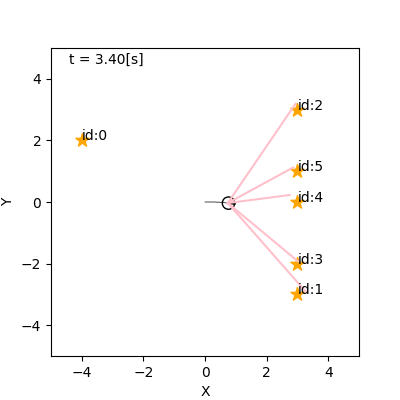

In [4]:
world = World(30, 0.1)  

### 地図を生成して3つランドマークを追加 ###
m = Map()                                  
m.append_landmark(Landmark(-4,2))
m.append_landmark(Landmark(3,-3))
m.append_landmark(Landmark(3,3))
m.append_landmark(Landmark(3,-2))
m.append_landmark(Landmark(3,0))
m.append_landmark(Landmark(3,1))
world.append(m)          

### ロボットを作る ###
straight = Agent(0.2, 0.0)    
r = Robot( np.array([ 0, 0, 0]).T, sensor=Camera(m), agent=straight) 
world.append(r)

### アニメーション実行 ###
world.draw()